In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time
from utils import *
from siamese import ProductDataset, SiameseNetwork, ContrastiveLoss

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### Dataset

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "data/multi_classed_grouped_data")
products = os.listdir(data_path)
product = products[0]
print(product)

product_path = os.path.join(data_path, product)
good_images_path = os.path.join(product_path, 'train')
defect_images_path = os.path.join(product_path, 'test/defect')

train_good_image_list, test_good_image_list, all_train_defect_image_list, all_test_defect_image_list = generate_train_test_set(product_path)
train_dict = dict(zip(train_good_image_list + all_train_defect_image_list, [1]*len(train_good_image_list) + [0]*len(all_train_defect_image_list)))
test_dict = dict(zip(test_good_image_list[1:] + all_test_defect_image_list, [1]*len(test_good_image_list[1:]) + [0]*len(all_test_defect_image_list)))
test_image_path = test_good_image_list[0]
model_image_dict = dict(zip([test_image_path], [1]))
len(train_dict.keys()), len(test_dict.keys())

bottle


(435, 108)

#### Hyperparameter set

In [3]:
learning_rate = 3e-4
batch_size = 8
epochs = 150
n_classes = len(np.unique(list(train_dict.values())))

/home/khoa-ys/Projects/Course/similarity_venv/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


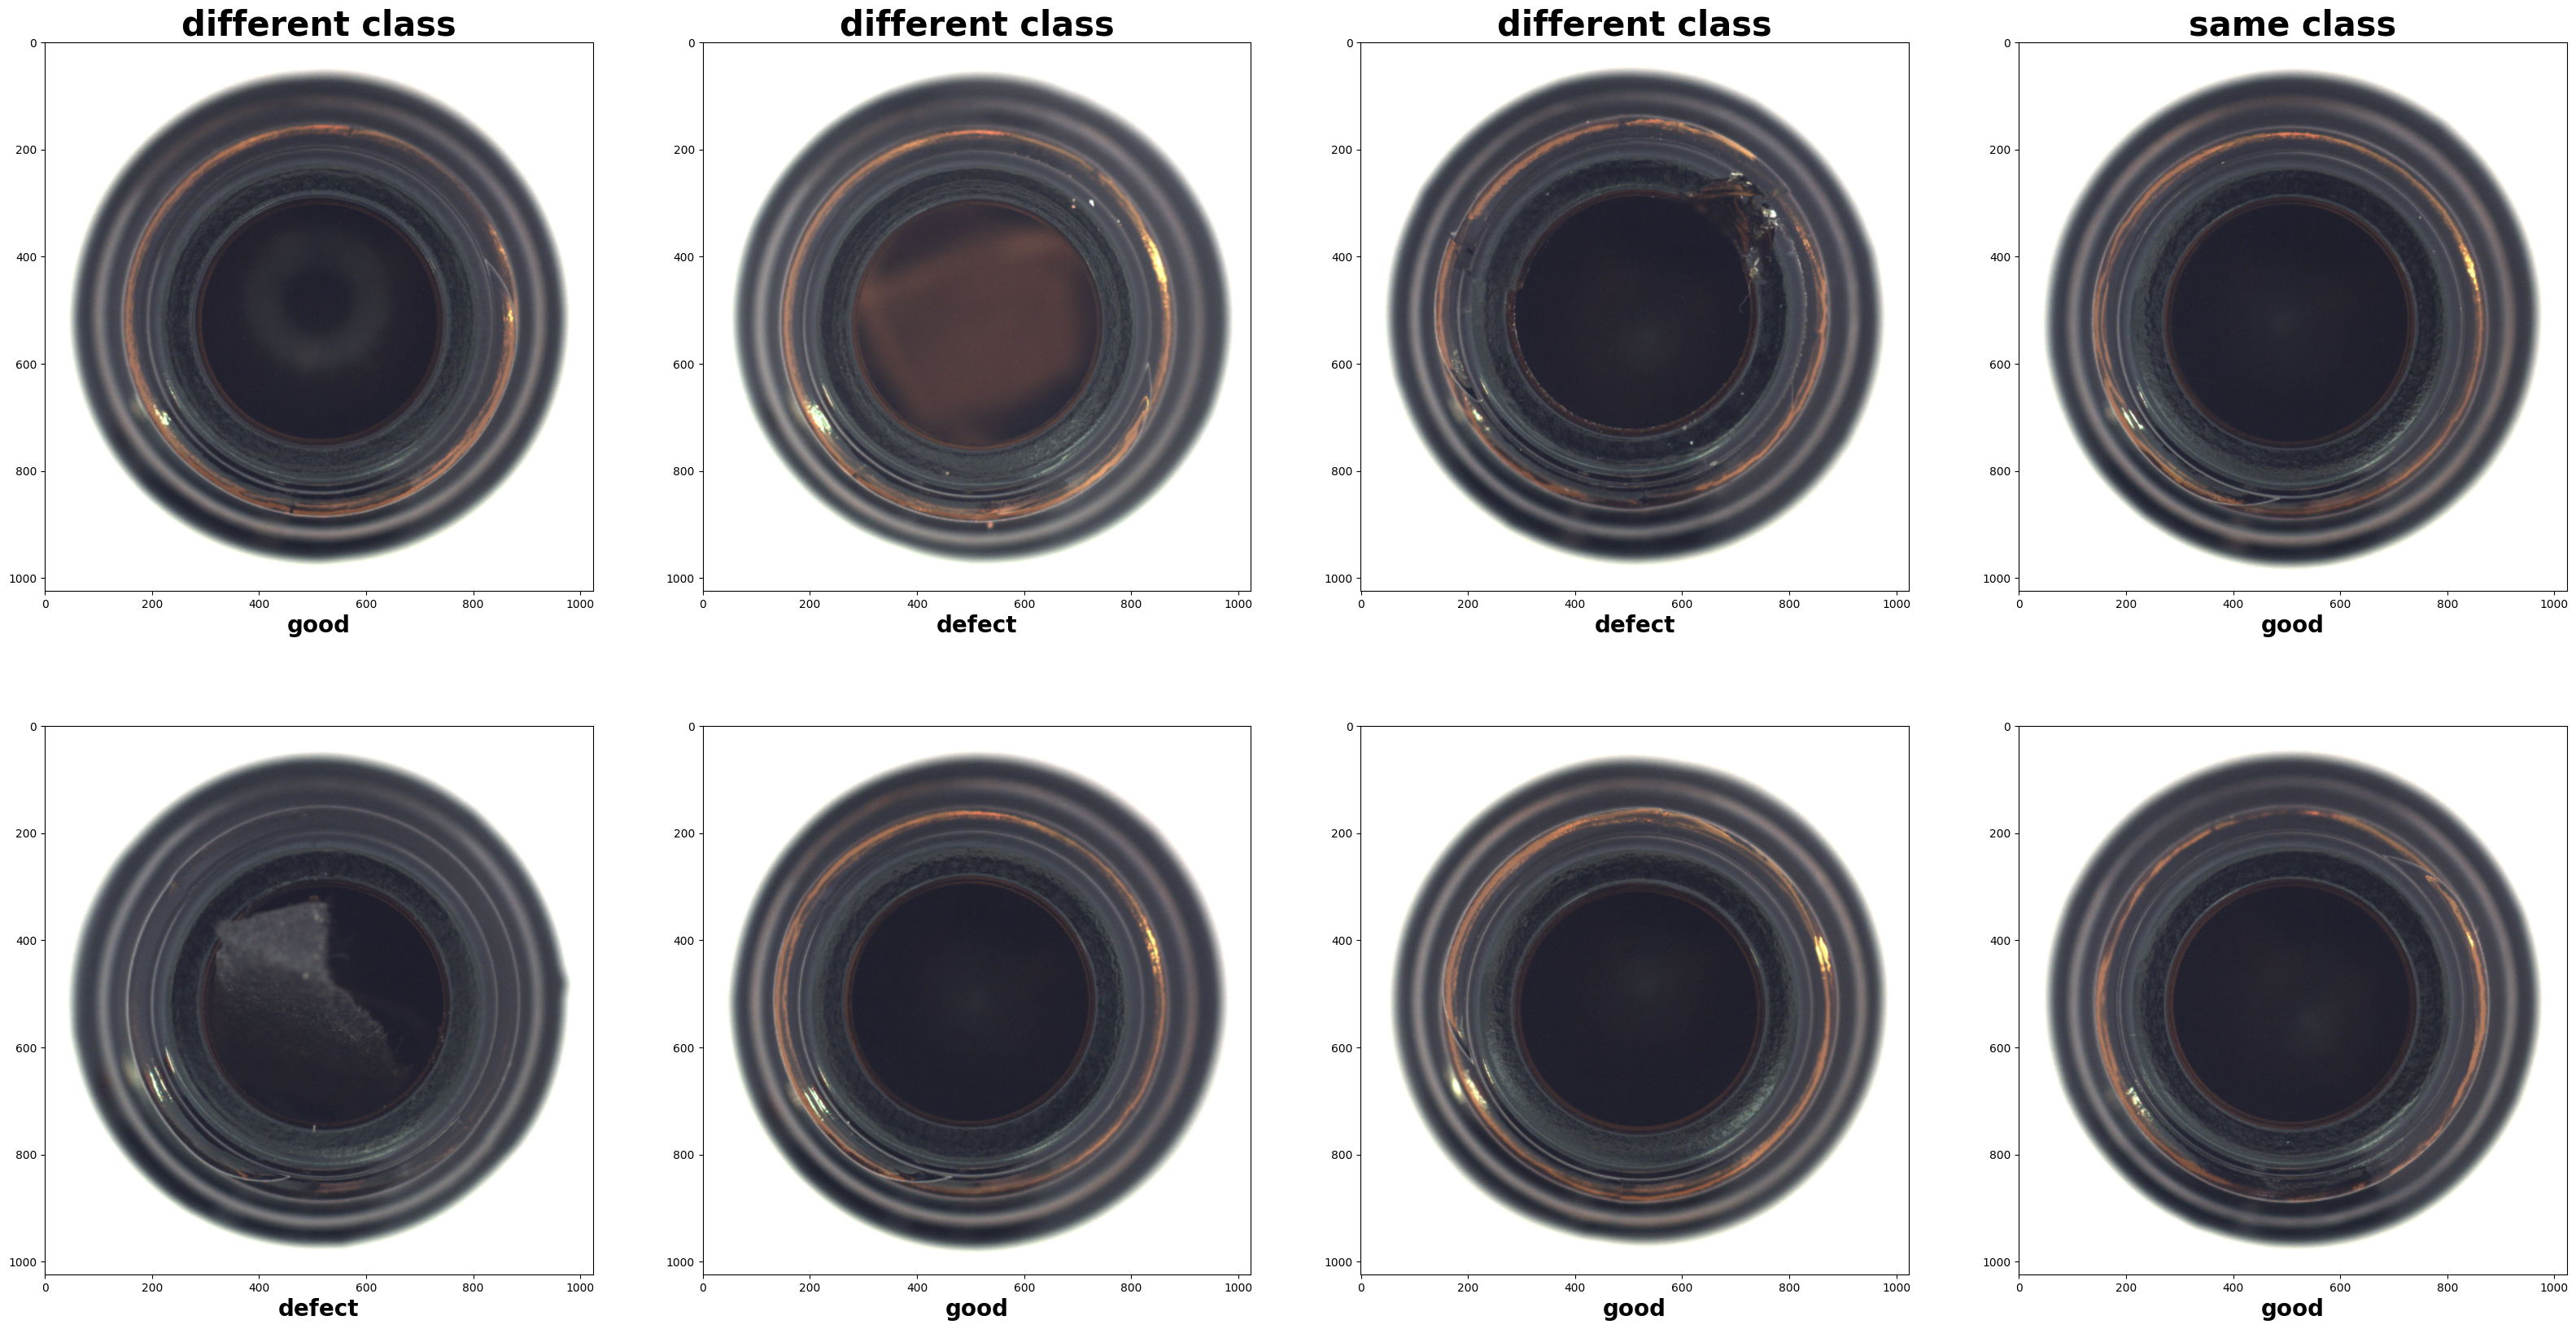

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((1024,1024)),
                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                ])

train_dataset = ProductDataset(image_label_dict=train_dict,
                                        transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Extract one batch
example_batch = next(iter(train_dataloader))

fig, ax = plt.subplots(2, 4, figsize=(40, 20))
for i in range(int(batch_size/2)):
    image_1 = np.array(example_batch[0][i].permute(1, 2, 0)*255, dtype=np.uint8)
    image_2 = np.array(example_batch[1][i].permute(1, 2, 0)*255, dtype=np.uint8)
    label_1, label_2 = example_batch[2][i].numpy()
    label_1 = "defect" if label_1 == 0 else "good"
    label_2 = "defect" if label_2 == 0 else "good"
    label = "same class" if example_batch[3][i].numpy()[0] == 0 else "different class"
    ax[0, i].imshow(image_1[:,:,::-1])
    ax[0, i].set_xlabel(label_1, weight = 'bold', fontsize = 20)
    #ax[0, i].axis('off')
    ax[1, i].imshow(image_2[:,:,::-1])
    ax[1, i].set_xlabel(label_2, weight = 'bold', fontsize = 20)
    #ax[1, i].axis('off')
    fig.axes[i].set_title(label, weight = 'bold', fontsize = 30)

#### Training

In [5]:
model = SiameseNetwork(n_classes).to(device)
loss = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr =learning_rate)

------------ Epoch: 0 ------------
Average loss 1.2913985306566411
Time elapsed: 72.47911357879639 sec

------------ Epoch: 1 ------------
Average loss 1.4530162128535185
Time elapsed: 33.51020932197571 sec

------------ Epoch: 2 ------------
Average loss 1.2734448709271171
Time elapsed: 33.099926710128784 sec

------------ Epoch: 3 ------------
Average loss 1.2891249987212094
Time elapsed: 32.90883016586304 sec

------------ Epoch: 4 ------------
Average loss 1.3658613080328161
Time elapsed: 32.90407657623291 sec

------------ Epoch: 5 ------------
Average loss 1.2026530428366227
Time elapsed: 33.354506492614746 sec

------------ Epoch: 6 ------------
Average loss 1.3315508918328718
Time elapsed: 32.97929286956787 sec

------------ Epoch: 7 ------------
Average loss 1.1320769553834742
Time elapsed: 32.68812274932861 sec

------------ Epoch: 8 ------------
Average loss 1.1386022925376893
Time elapsed: 32.75032711029053 sec

------------ Epoch: 9 ------------
Average loss 1.202931329337

/tmp/ipykernel_17172/2083255315.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


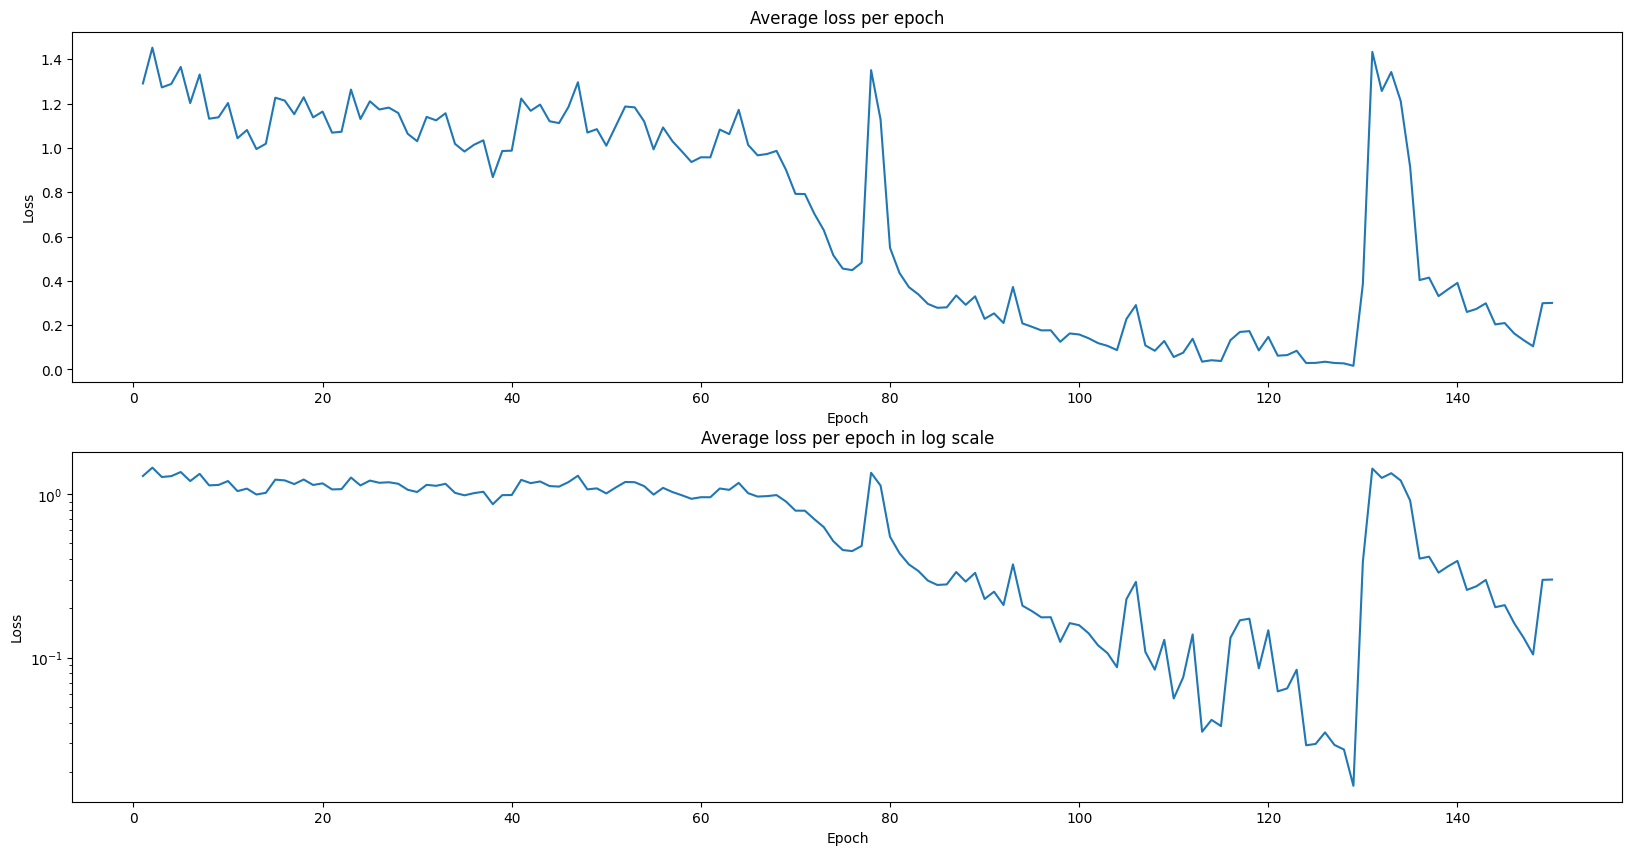

In [6]:
torch.cuda.empty_cache()
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(epochs):
    
    print("------------ Epoch:", epoch, "------------")
    # Iterate over batches
    epoch_loss = 0
    iter_number = 0
    start = time.time()
    for i, (image_1, image_2, class_label, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        image_1, image_2, label = image_1.to(device), image_2.to(device), label.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Pass in the two images into the network and obtain two outputs
        output_1, output_2 = model(image_1, image_2)
        
        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = loss(output_1, output_2, label)
        
        # Calculate the backpropagation
        loss_contrastive.backward()
        
        # Optimize
        optimizer.step()
        
        # Every 10 batches print out the loss
        iter_loss = loss_contrastive.item()
        epoch_loss += iter_loss
        iter_number += 1
    
    avg_loss = epoch_loss/iter_number
    print(f"Average loss {avg_loss}")
    
    end = time.time()
    print("Time elapsed:", end - start,"sec\n")
    
    loss_history.append(avg_loss)


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(range(1, epochs+1), loss_history)
ax[0].set_title("Average loss per epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(range(1, epochs+1), loss_history)
ax[1].set_yscale("log")
ax[1].set_title("Average loss per epoch in log scale")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
fig.show()
torch.cuda.empty_cache()

In [7]:
# Save model parameters
save_model = False
if save_model:
    torch.save(model.state_dict(), os.path.join(root_path, 'models/siamese_resnet16_subclass_sampling.pth'))

#### Testing

{"/media/khoa-ys/Personal/Materials/Master's Thesis/image_similarity_assessment/data/multi_classed_grouped_data/bottle/train/103.png": 1}


/tmp/ipykernel_17172/3120919774.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


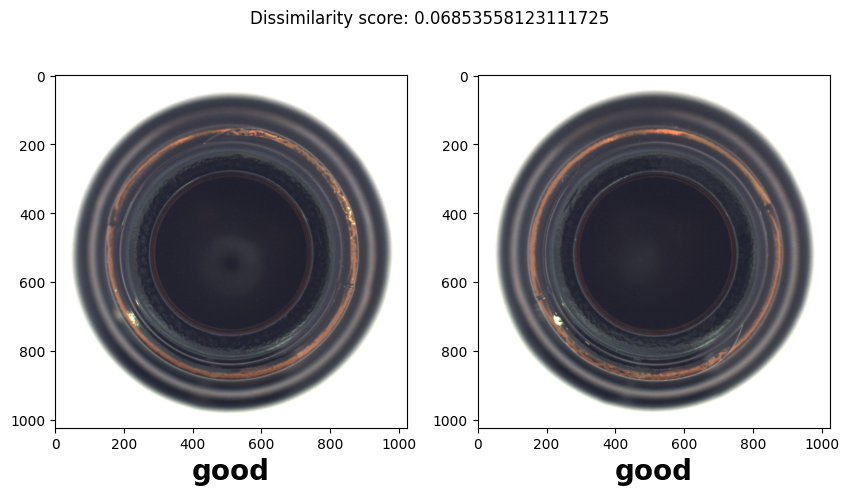

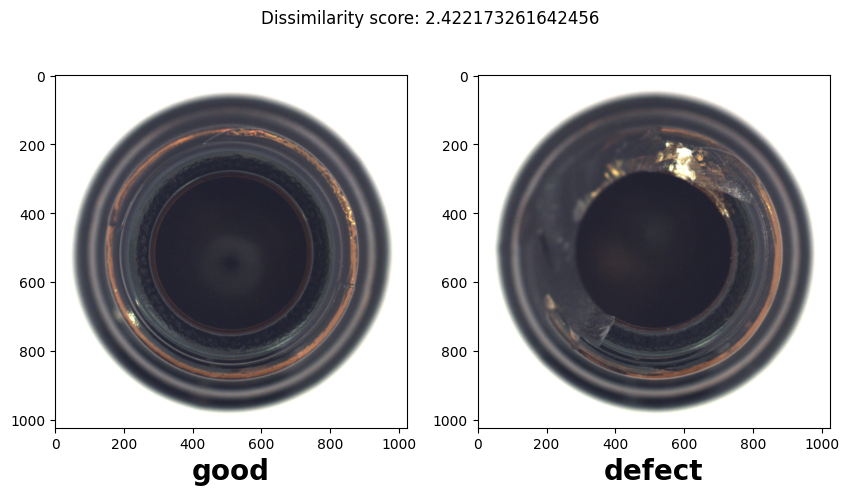

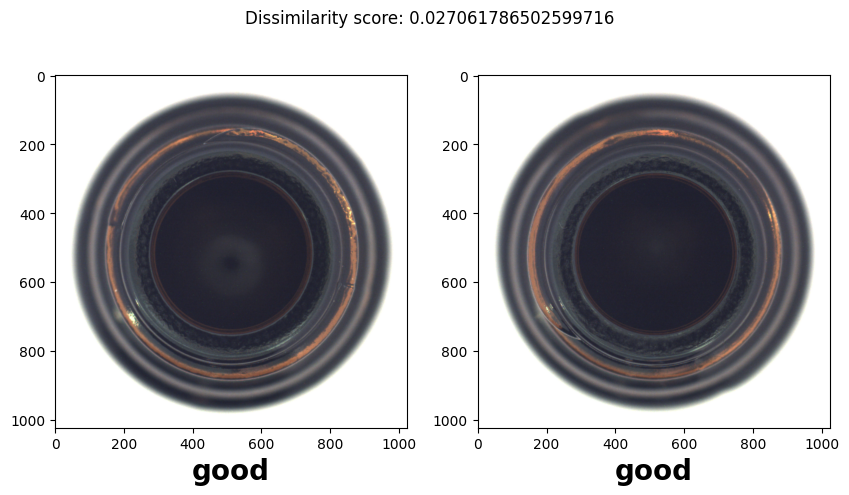

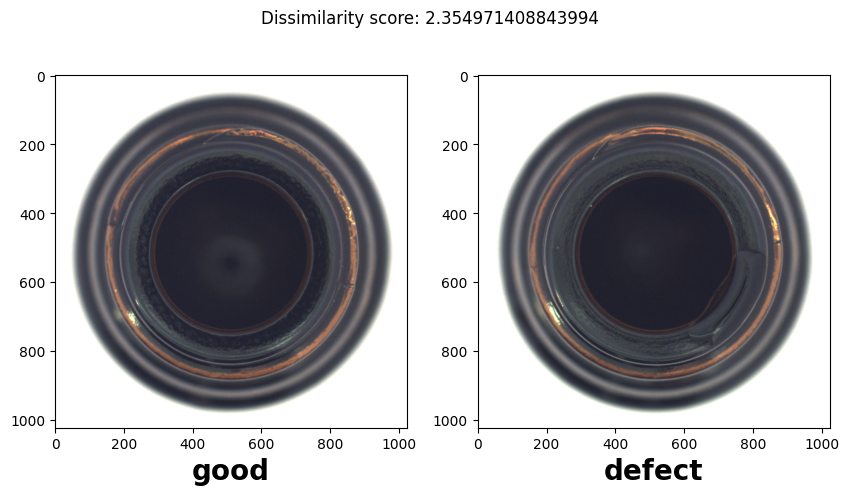

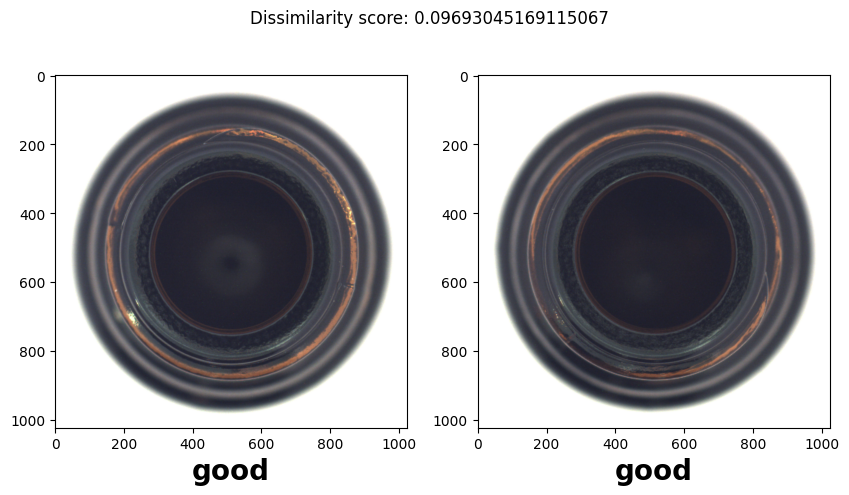

In [8]:
model = SiameseNetwork(n_classes).to(device)
model.load_state_dict(torch.load(os.path.join(root_path, 'models/siamese_resnet16_subclass_sampling.pth')))
model.eval()
test_image = cv2.imread(test_image_path, cv2.IMREAD_UNCHANGED)
model_dataset = ProductDataset(image_label_dict=model_image_dict,
                                        transform=transform)
model_dataloader = DataLoader(model_dataset, batch_size=1, shuffle=True) 

test_dataset = ProductDataset(image_label_dict=test_dict,
                                        transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Extract one batch
model_image, _, model_label, _ = next(iter(model_dataloader))

result = []
for i in range(len(list(test_dict.keys()))):
    _, test_image, test_label, _ = next(iter(test_dataloader))
    
    output_1, output_2 = model(model_image.to(device), test_image.to(device))
    euclidean_distance = F.pairwise_distance(output_1, output_2, keepdim=True)

    image_1 = np.array(model_image[0].permute(1, 2, 0)*255, dtype=np.uint8)
    test_image = np.array(test_image[0].permute(1, 2, 0)*255, dtype=np.uint8)
    label_1 = "good"
    label_2 = "defect" if test_label.numpy()[0][1] == 0 else "good"
    label = "same class" if label_1 == label_2 else "different class"

    if i <= 4:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image_1[:,:,::-1])
        ax[0].set_xlabel(label_1, weight = 'bold', fontsize = 20)
        #ax[0].axis('off')
        ax[1].imshow(test_image[:,:,::-1])
        ax[1].set_xlabel(label_2, weight = 'bold', fontsize = 20)
        #ax[1].axis('off')
        fig.suptitle('Dissimilarity score: ' + str(euclidean_distance.item()))
        fig.show()
    result.append(np.array([1., test_label.numpy()[0][1], 1. == test_label.numpy()[0][1], euclidean_distance.item()]))
    torch.cuda.empty_cache()
result = np.array(result)
np.savetxt(os.path.join(root_path, 'result/siamese_resnet16_subclass_sampling.csv'), result, delimiter=",")

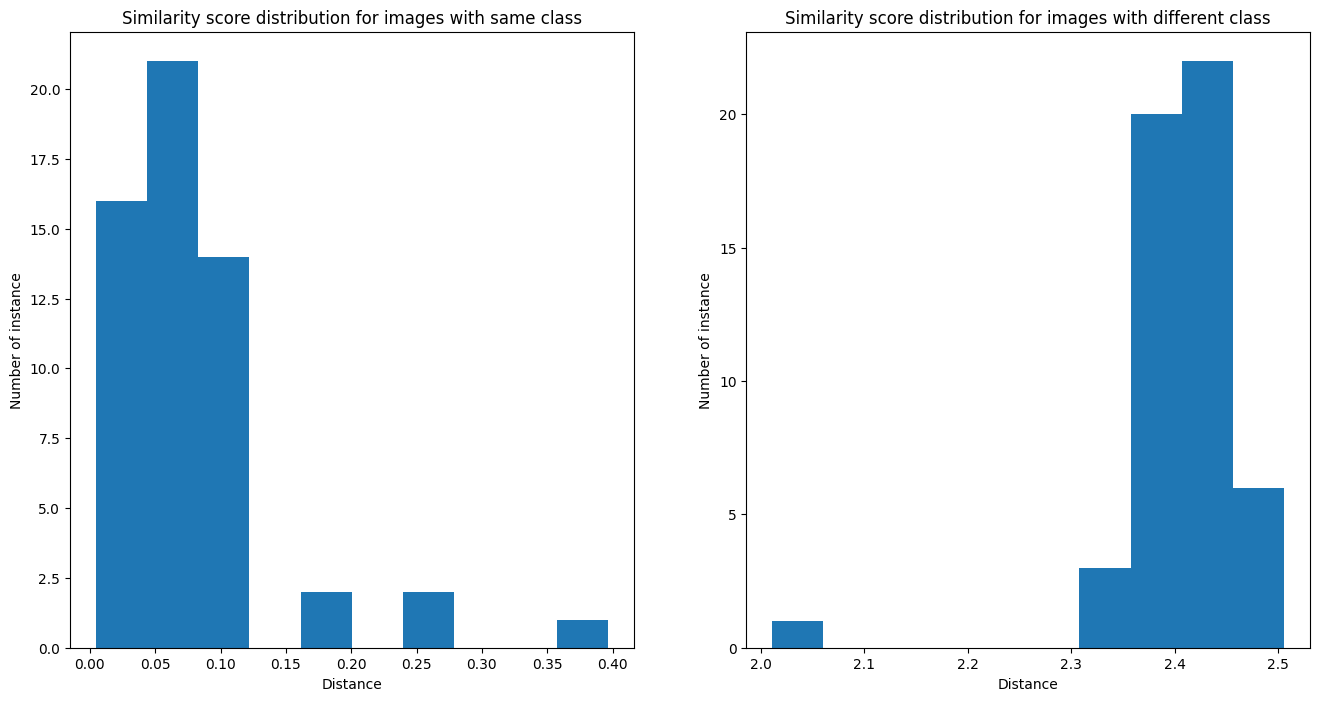

In [9]:
same_class = result[:,2]
similarity_scores = result[:,3]

dissimillar_idx = np.where(same_class == 0)
dissimillar_score = similarity_scores[dissimillar_idx]
simillar_idx = np.where(same_class == 1)
simillar_score = similarity_scores[simillar_idx]
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].hist(simillar_score)
ax[0].set_xlabel('Distance', fontsize = 10)
ax[0].set_ylabel('Number of instance', fontsize = 10)
ax[0].set_title('Similarity score distribution for images with same class')
ax[1].hist(dissimillar_score)
ax[1].set_xlabel('Distance', fontsize = 10)
ax[1].set_ylabel('Number of instance', fontsize = 10)
ax[1].set_title('Similarity score distribution for images with different class')
fig.savefig(root_path + '/Figure/similarity_score_distribution.png')